In [1]:
import os
import glob
import numpy as np
import email
from sklearn.model_selection import train_test_split

In [2]:
path = r"D:\Gustavo\Github\Portfolio\Spam Email Detection/Data/"

In [3]:
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [4]:
def get_email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

In [5]:
ham_path = [
    easy_ham_paths,
    easy_ham_2_paths,
    hard_ham_paths
]

spam_path = [
    spam_paths,
    spam_2_paths
]

In [6]:
# List of email contents obtained using get_email_content_bulk
ham_emails = get_email_content_bulk([item for sublist in ham_path for item in sublist])

# Split the HAM emails into training and testing sets
ham_train, ham_test = train_test_split(ham_emails, test_size=0.25, random_state=42)

# Convert to NumPy arrays
ham_train = np.array(ham_train)
ham_test = np.array(ham_test)

In [7]:
# List of email contents obtained using get_email_content_bulk
spam_emails = get_email_content_bulk([item for sublist in spam_path for item in sublist])

# Split the SPAM emails into training and testing sets
spam_train, spam_test = train_test_split(spam_emails, test_size=0.25, random_state=42)

# Convert to NumPy arrays
spam_train = np.array(spam_train)
spam_test = np.array(spam_test)

In [8]:
# Creating Labels for Ham Training Data:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]

# Combining Ham and Spam Training Data:
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

# Creating Labels for Ham Test Data:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]

# Combining Ham and Spam Test Data:
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [9]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))


x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]


x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [10]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

### Pre Processing ###

## Cleaning ##

In [11]:
import re
import string
from nltk.tokenize import word_tokenize

In [12]:
class TextCleaner:
    def __init__(self):
        self.cleaning_utils = [
            self.remove_hyperlink,
            self.to_lower,
            self.remove_number,
            self.remove_punctuation,
            self.remove_whitespace,
            self.replace_newline
        ]

    def remove_hyperlink(self, word):
        return re.sub(r"https?://\S+", "", word)

    def to_lower(self, word):
        return word.lower()

    def remove_number(self, word):
        return re.sub(r'\d+', '', word)

    def remove_punctuation(self, word):
        return word.translate(str.maketrans("", "", string.punctuation))

    def remove_whitespace(self, word):
        return word.strip()

    def replace_newline(self, word):
        return word.replace('\n', ' ')

    def clean_up_pipeline(self, sentence):
        for cleaning_util in self.cleaning_utils:
            sentence = cleaning_util(sentence)
        return sentence

In [13]:
text_cleaner = TextCleaner()

x_train_clean = [text_cleaner.clean_up_pipeline(o) for o in x_train]
x_test_clean = [text_cleaner.clean_up_pipeline(o) for o in x_test]

In [14]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('wordnet')
#nltk.download('punkt')

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [16]:
# Tokenization

x_train_token = [word_tokenize(o) for o in x_train_clean]
x_test_token = [word_tokenize(o) for o in x_test_clean]

In [17]:
class Tockenization:
    def __init__(self):
        self.cleaning_utils = [
            self.remove_stop_words,
            self.word_lemmatizer
            ]

    def remove_stop_words(self, words):
        result = [i for i in words if i not in sklearn_stop_words]
        return result

    def word_stemmer(self, words):
        return [stemmer.stem(o) for o in words]

    def word_lemmatizer(self, words):
        return [lemmatizer.lemmatize(o) for o in words]

    def clean_token_pipeline(self, words):
        for cleaning_utils in self.cleaning_utils:
            words = cleaning_utils(words)
        return words
    
text_token = Tockenization()

In [18]:
x_train_tokenized = [text_token.clean_token_pipeline(o) for o in x_train_token]
x_test_tokenized = [text_token.clean_token_pipeline(o) for o in x_test_token]

In [19]:
x_train_cleaned = [" ".join(o) for o in x_train_tokenized]
x_test_cleaned = [" ".join(o) for o in x_test_tokenized]

### Visualization ###

In [49]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [39]:
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]

In [40]:
spam_email = np.array(x_train_cleaned)[spam_train_index]
non_spam_email = np.array(x_train_cleaned)[non_spam_train_index]

In [57]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=50, figure_size=(12,8), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

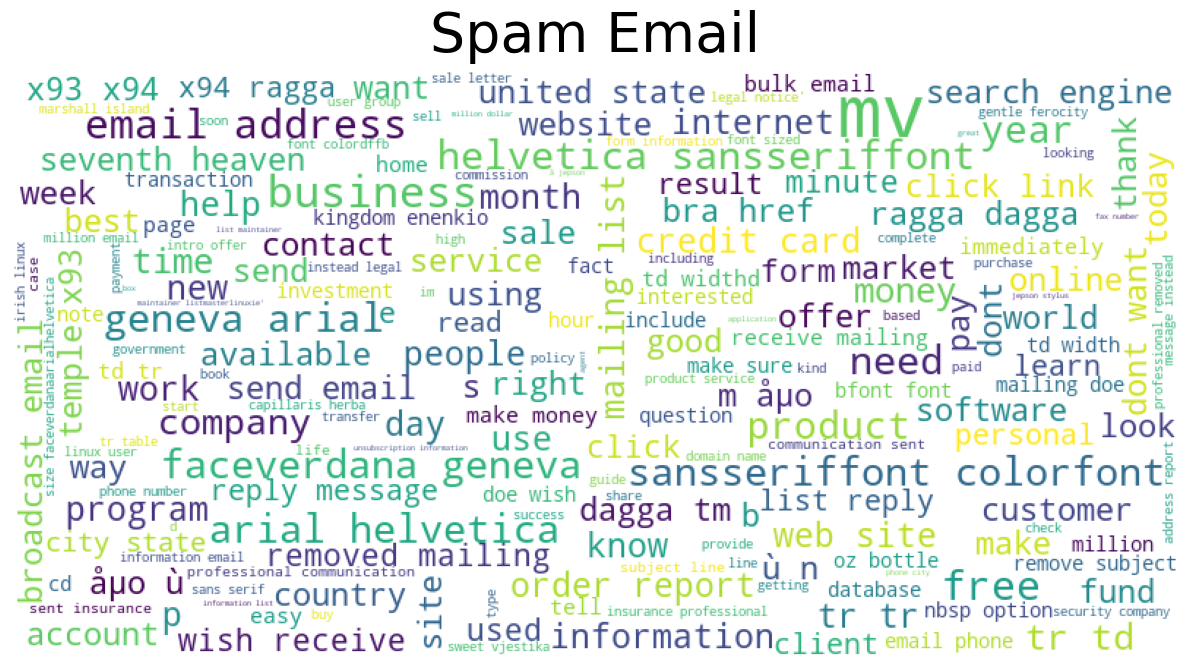

In [58]:
plot_wordcloud(spam_email,title = 'Spam Email')

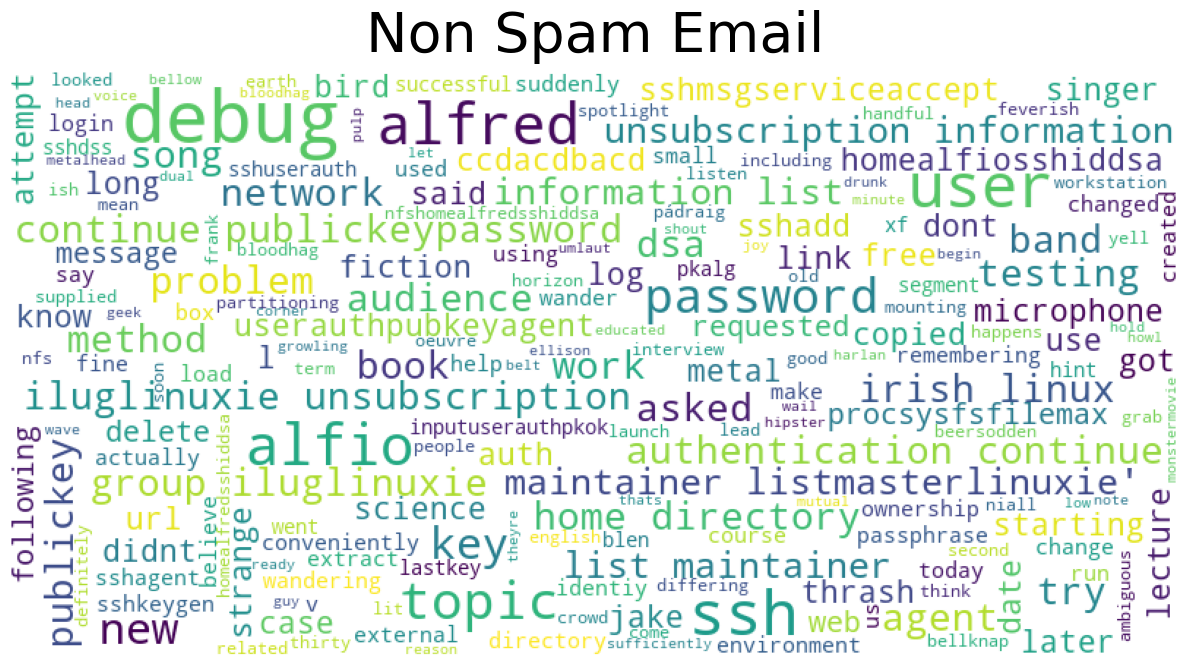

In [59]:
plot_wordcloud(non_spam_email,title="Non Spam Email")

# **Feature Extraction** #

In [20]:
x_train_splited = [o.split(" ") for o in x_train_cleaned]
x_test_splited = [o.split(" ") for o in x_test_cleaned]

### TF-IDF Vectorizer ###

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vectorizer = TfidfVectorizer()
raw_sentences = [' '.join(o) for o in x_train_splited]
vectorizer.fit(raw_sentences)

TfidfVectorizer()

In [23]:
def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(o) for o in raw_tokenize_data]
    return vectorizer.transform(raw_sentences)

In [24]:
x_train_vectorized = convert_to_feature(x_train_splited)
x_test_vectorized = convert_to_feature(x_test_splited)

### WordEmbebing ###

# **Training classifier** #

### Gaussian NB

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [26]:
gnb = GaussianNB()
gnb.fit(x_train_vectorized.toarray(),y_train)

GaussianNB()

In [27]:
gnb.score(x_test_vectorized.toarray(),y_test)

0.9260969976905312

In [28]:
gnb.score(x_train_vectorized.toarray(),y_train)

0.9918996603083355

### Linear SVC

In [29]:
from sklearn.svm import LinearSVC

In [30]:
lsvc = LinearSVC()
lsvc.fit(x_train_vectorized.toarray(),y_train)

d:\Gustavo\Github\Portfolio\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [31]:
lsvc.score(x_test_vectorized.toarray(),y_test)

0.9799846035411856

### Results Visualization

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [33]:
y_predict_GNB = gnb.predict(x_test_vectorized.toarray())
y_predict_LSVC = lsvc.predict(x_test_vectorized.toarray())

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict_GNB).ravel()

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict_GNB)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict_GNB)))

Precision: 84.29%
Recall: 80.00%


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

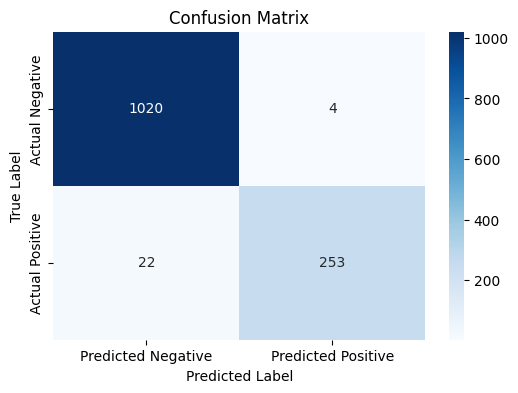

Accuracy: 0.98
Precision: 0.98
Recall: 0.92


In [64]:
# Assuming y_true and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_predict_LSVC)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy, precision, and recall
accuracy = (cm[0, 0] + cm[1, 1]) / sum(sum(cm))
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')